# IPython parallel

Jupyter prilično jednostavno omogućava paralelizaciju koda. Dokumentaciju možete naći ovdje: [Using IPython for parallel computing](http://ipython.org/ipython-doc/dev/parallel/).

No modifikacija Jupyter notebook u Sagemath oblaku to ne omogućuje. No u Sagemath oblaku možemo pokretnuti _čisti_ Jupyter notebook tako što u otvorimo link oblika
```
https://cloud.sagemath.com/[id_projekta]/port/jupyter
``` 
u pregledniku. Kako se ovim pokreće server, možda je potrebno poslije nekoliko sekundi osvježiti stranicu.

Dobit ćemo _Jupyter Dashboard_, s popisom notebooka. Ako kliknemo na menu _Clusters_ možemo podesiti broj procesora (_# of engines_). Stavimo recimo na 4. 

U nastavku ćemo pokazati na jednostavnom primjeru kako koristiti paralelizaciju u Jupyter notebooku.

In [1]:
from IPython.parallel import Client

In [2]:
cli = Client()

S atributom `ids` dobijamo listu procesora u klasteru:

In [3]:
cli.ids

[0, 1, 2, 3]

Sada možemo izabirati što se izvodi na kojem procesoru.

In [4]:
def getpid():
    """ vraća jedinstveni ID trenutnog procesora """
    import os
    return os.getpid()

In [5]:
# procesor u kojem se vrti notebook
getpid()

10108

In [6]:
# na prvom procesoru
cli[0].apply_sync(getpid)

27199

In [7]:
# na svim procesorima
cli[:].apply_sync(getpid)

[27199, 27200, 27201, 27214]

Najjednostavnije korištenje je pomoću dekoratora:

    @view.parallel(block=True)

Primjer:

In [8]:
dview = cli[:]

In [9]:
@dview.parallel(block=True)
def dummy_task(delay):
    """ funkcija koja ništa ne radi """
    import os, time

    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()
    
    return [pid, t0, t1]

In [10]:
# generiramo slučajno kašnjenje
import numpy
delay_times = numpy.random.rand(4)

Da bi mapirali funkciju `dummy_task` na podatke, koristimo `map` metodu u `dummy_task`:

In [11]:
dummy_task.map(delay_times)

[[27199, 1428597985.888589, 1428597986.192964],
 [27200, 1428597985.889377, 1428597986.296258],
 [27201, 1428597985.893522, 1428597986.028034],
 [27214, 1428597985.89323, 1428597986.890921]]

Napravimo sada to na više zadataka i vizualizirajmo što se dešava:

In [18]:
from matplotlib.pyplot import *
%matplotlib inline
def visualize_tasks(results):
    res = numpy.array(results)
    fig, ax = subplots(figsize=(10, res.shape[1]))
    
    yticks = []
    yticklabels = []
    tmin = min(res[:,1])
    for n, pid in enumerate(numpy.unique(res[:,0])):
        yticks.append(n)
        yticklabels.append("%d" % pid)
        for m in numpy.where(res[:,0] == pid)[0]:
            ax.add_patch(Rectangle((res[m,1] - tmin, n-0.25),res[m,2] - res[m,1], 0.5, color="green", alpha=0.5))    
    ax.set_ylim(-.5, n+.5)
    ax.set_xlim(0, max(res[:,2]) - tmin + 0.)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("PID")
    ax.set_xlabel("sekunde")

In [13]:
delay_times = numpy.random.rand(64)

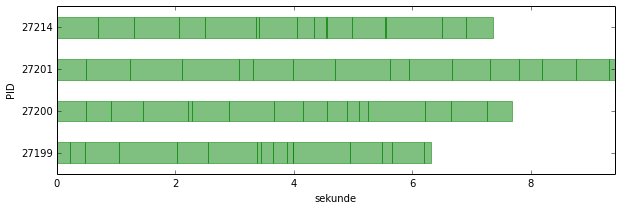

In [19]:
result = dummy_task.map(delay_times)
visualize_tasks(result)

Za balansiranje možemo koristiti `load_balanced_view` metodu:

In [20]:
lbview = cli.load_balanced_view()

In [21]:
@lbview.parallel(block=True)
def dummy_task_load_balanced(delay):
    """ funkcija koja ništa ne radi  """
    import os, time

    t0 = time.time()
    pid = os.getpid()
    time.sleep(delay)
    t1 = time.time()
    
    return [pid, t0, t1]

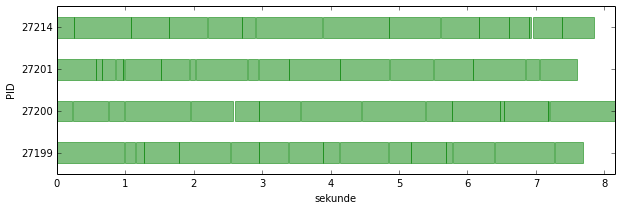

In [22]:
result = dummy_task_load_balanced.map(delay_times)
visualize_tasks(result)

Vidimo da su sada procesori bolje iskorišteni.